## 潜在変数モデル
ラベルスイッチの起き方の説明用サンプル

<a href="https://colab.research.google.com/github/makaishi2/python_bayes_intro/blob/main/sample-notebooks/FAQ_%E6%BD%9C%E5%9C%A8%E5%A4%89%E6%95%B0%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 共通処理

In [1]:
#%matplotlib inline
# 日本語化ライブラリ導入
#!pip install japanize-matplotlib | tail -n 1

In [2]:
# ライブラリのimport
import pymc as pm
import arviz as az

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

### 5.4.1 問題設定
アイリスデータセットで特定項目の値のみを利用する。  
花の種別の情報をなしで、2種類の花の統計的特徴を推論する。


### 5.4.2 データ準備

#### データ読み込みと確認

In [3]:
# アイリスデータセットの読み込み
df = sns.load_dataset('iris')

#### 分析対象データの絞り込み


In [4]:
# 花の種類をsetosa以外の２種類に絞り込む
df2 = df.query('species != "setosa"')

# インデックスを0から振り直す
df2 = df2.reset_index(drop=True)

# petal_widthの項目値をx_dataにセット
X = df2['petal_width'].values

### 5.4.3 確率モデル定義

#### 潜在変数モデルの確率モデル定義

In [5]:
# 変数の初期設定

# 何種類の正規分布モデルがあるか
n_components = 2

# 観測データ件数
N = X.shape

model1 = pm.Model()

with model1:
    # Xの観測値をConstantDataとして定義
    X_data = pm.ConstantData('X_data', X)

    # p: 潜在変数が1の値をとる確率
    p = pm.Uniform('p', lower=0.0, upper=1.0)

    # s: 潜在変数pの確率値をもとに0, 1のいずれかの値を返す
    s = pm.Bernoulli('s', p=p, shape=N)

    # mus: ２つの花の種類毎の平均値
    mus = pm.Normal('mus', mu=0.0, sigma=10.0, shape=n_components)

    # taus: 2つの花の種類毎のバラツキ
    # 標準偏差sigmasとの間にはtaus = 1/(sigmas*sigmas)の関係がある
    taus = pm.HalfNormal('taus', sigma=10.0, shape=n_components)

    # グラフ描画など分析でsigmasが必要なため、tausからsigmasを求めておく
    sigmas = pm.Deterministic('sigmas', 1/pm.math.sqrt(taus))

    # 各観測値ごとに潜在変数からmuとtauを求める
    mu = pm.Deterministic('mu', mus[s])
    tau = pm.Deterministic('tau', taus[s])

    # 正規分布に従う確率変数X_obsの定義
    X_obs = pm.Normal('X_obs', mu=mu, tau=tau, observed=X_data)

### 5.4.4 サンプリングと結果分析

#### サンプリング

In [6]:
with model1:
    idata1_2 = pm.sample(target_accept=0.99, chains=5,
      random_seed=42)

Multiprocess sampling (5 chains in 4 jobs)
CompoundStep
>NUTS: [p, mus, taus]
>BinaryGibbsMetropolis: [s]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 83 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### plot_trace関数で推論結果の確認

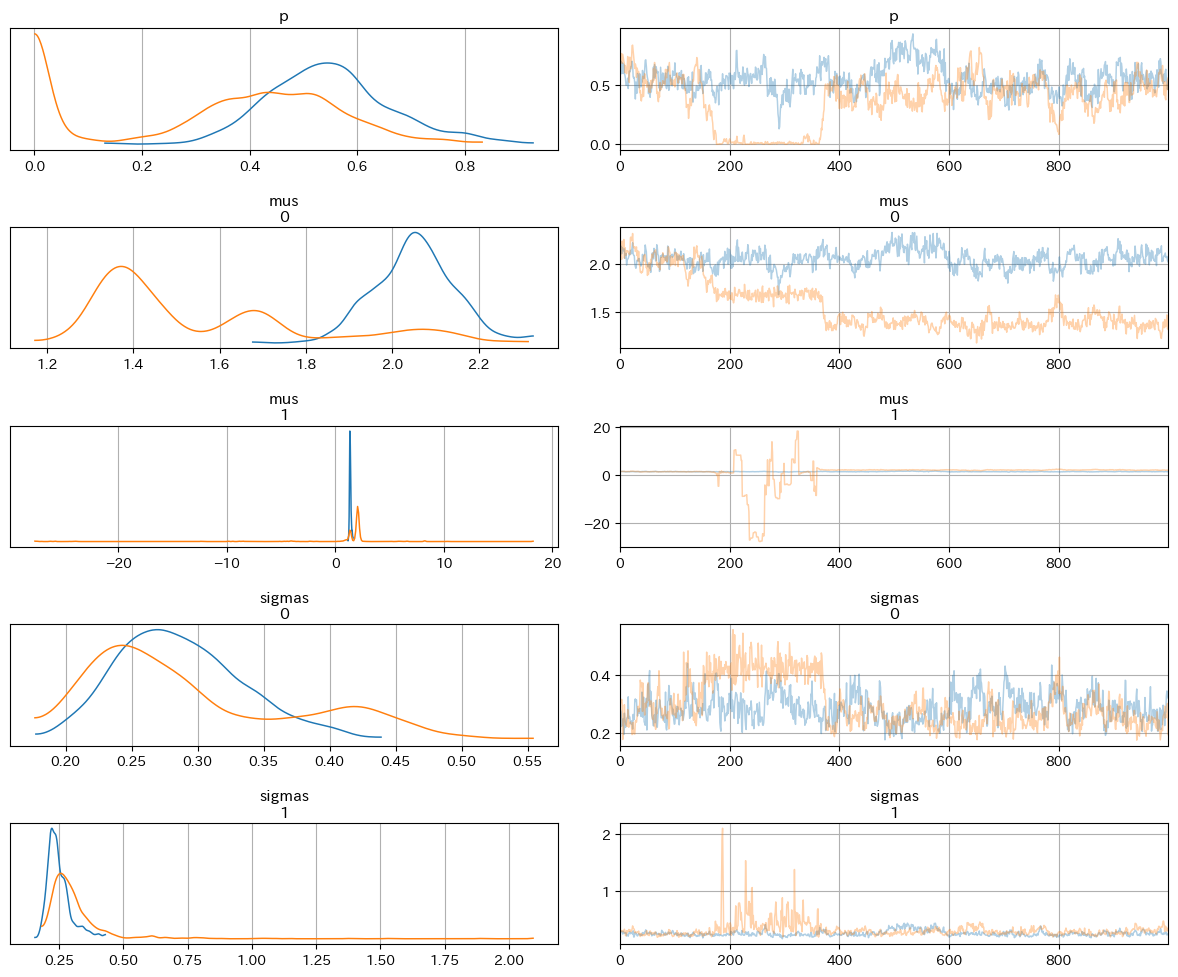

In [7]:
# 最初の２つのchainのみ抽出
az.plot_trace(idata1_2, var_names=['p', 'mus', 'sigmas'], coords={"chain": [0, 1]}, compact=False)
plt.tight_layout();

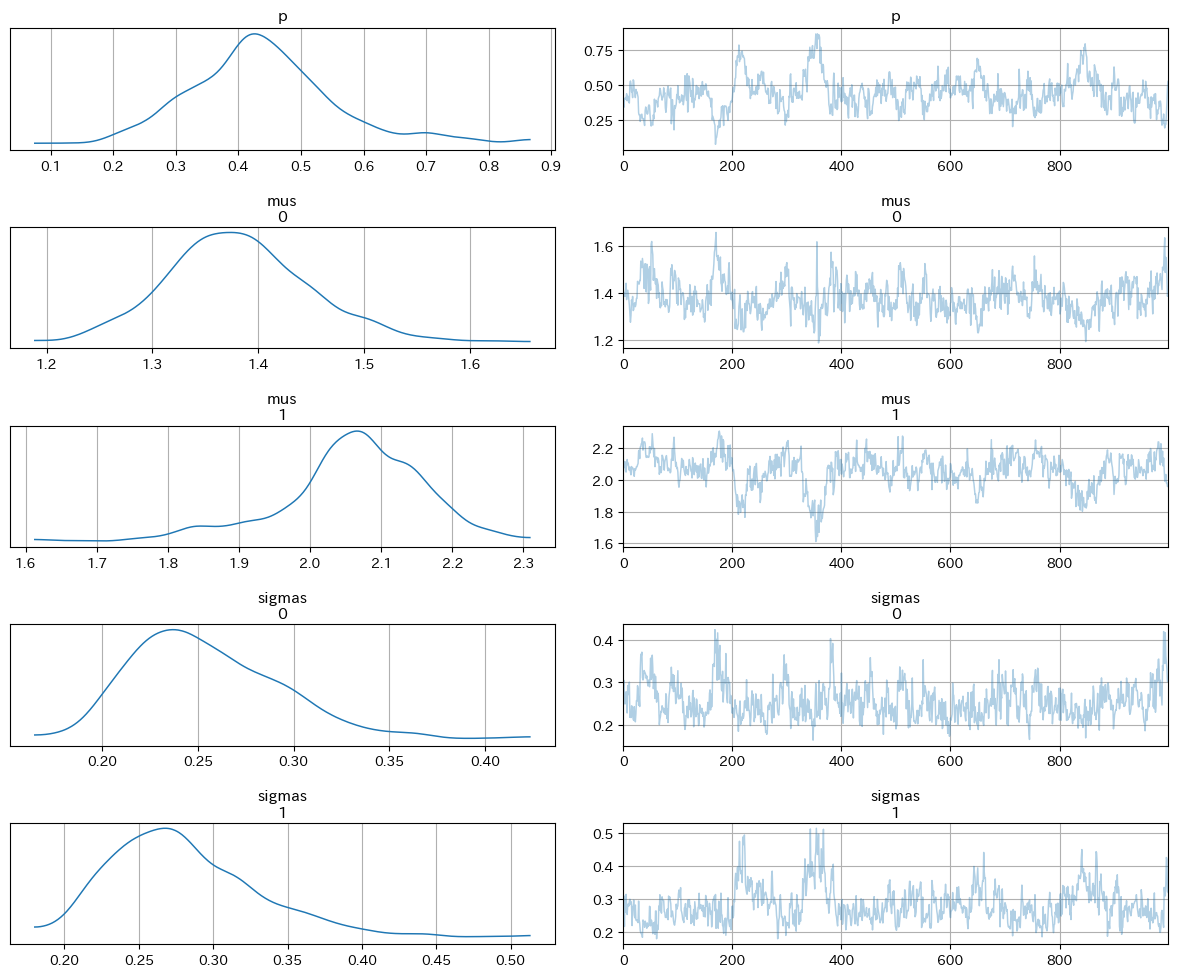

In [8]:
# 3番目のchainのみ抽出
az.plot_trace(idata1_2, var_names=['p', 'mus', 'sigmas'], coords={"chain": [2]}, compact=False)
plt.tight_layout();

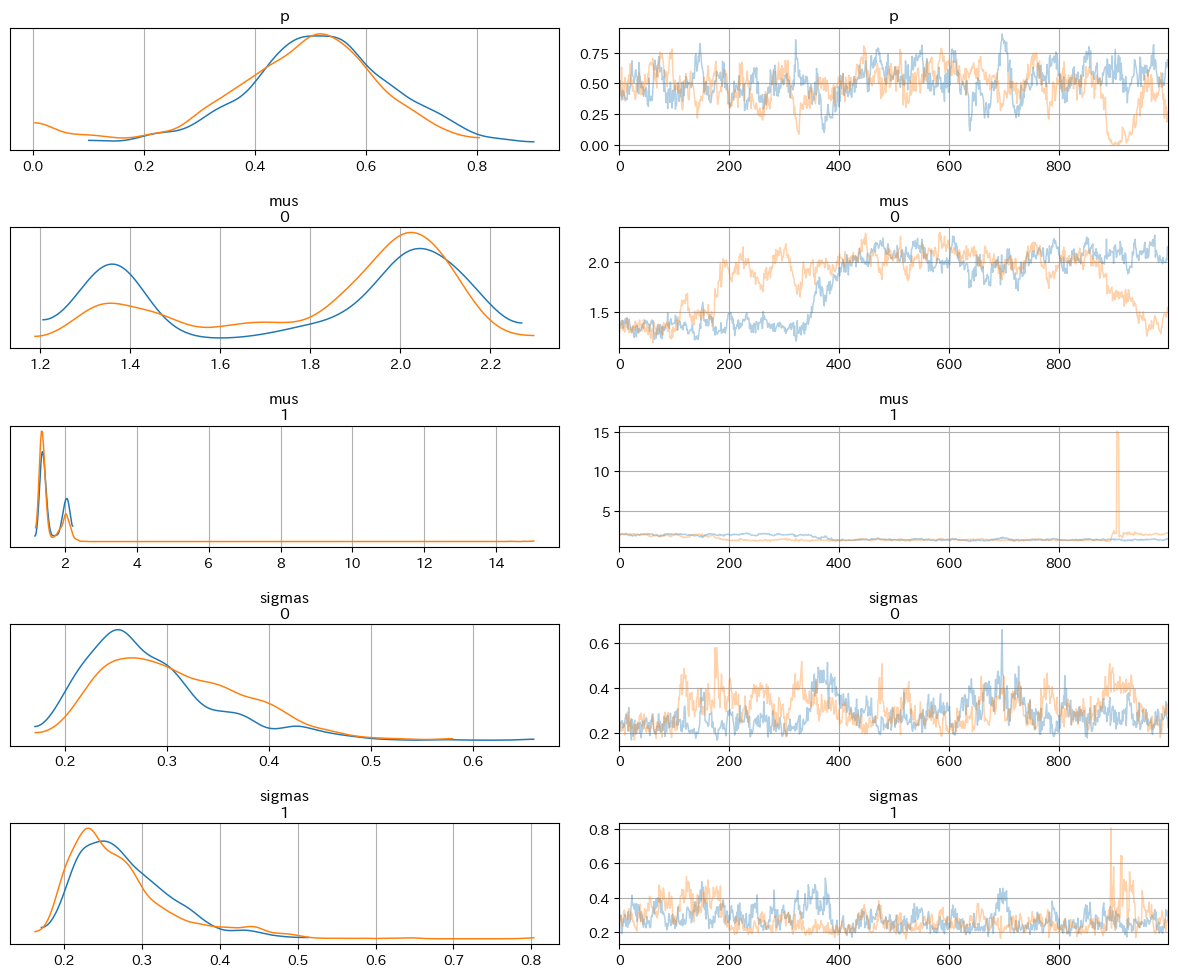

In [9]:
# 最後の２つのchainのみ抽出
az.plot_trace(idata1_2, var_names=['p', 'mus', 'sigmas'], coords={"chain": [3, 4]}, compact=False)
plt.tight_layout();

In [10]:
#!pip install watermark | tail -n 1
%load_ext watermark
%watermark --iversions

pymc               : 5.11.0
pandas             : 2.2.1
matplotlib         : 3.8.3
arviz              : 0.17.1
seaborn            : 0.12.2
japanize_matplotlib: 1.1.3
numpy              : 1.26.4

